# Data Structure

This notebook will cover:

Exercise 2.*

Using different types of data structure to transform time-series into event-driven order.

Instead of market price time-series, we form somewhat an transaction volume expectation to total transaction volume to resample data.

Using such data structure could generate good market signal for different plausible quant strategies.

In order to appreciate this technique, I highly recommend you to read the below research.

[Volume Clock SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2034858)

**Note**

If actual High-frequency data is not within your reach, you may wish to try with the below code:

    def create_price_data(start_price: float = 1000.00,
                          mu: float = .0,
                          var: float = 1.0,
                          n_samples: int = 1000000):
                          
        import numpy as np
        import pandas as pd

        i = np.random.normal(mu, var, n_samples)
        df0 = pd.date_range(periods=n_samples,
                            freq=pd.tseries.offsets.Minute(),
                            end=pd.datetime.today())
                            
        X = pd.Series(i, index=df0, name = "close").to_frame()
        X.close.iat[0] = start_price
        X.cumsum().plot.line()
        return X.cumsum()

The above function can generate about 2 years of synthetic raw data, so that you can start to structure your data into dollar bars.

Please remember to save this as your sample data to csv format, otherwise, your result may not be consistant. (This sample data can get you started for 1st 5 chapters)

Contact: boyboi86@gmail.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

p = print

#pls take note of version
#numpy 1.17.3
#pandas 1.0.3
#sklearn 0.21.3

In [2]:
# Intraday sample data courtesy of mlfinlab

dollar = pd.read_csv('./Sample_data/dollar_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])

volume = pd.read_csv('./Sample_data/volume_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])

tick = pd.read_csv('./Sample_data/tick_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])

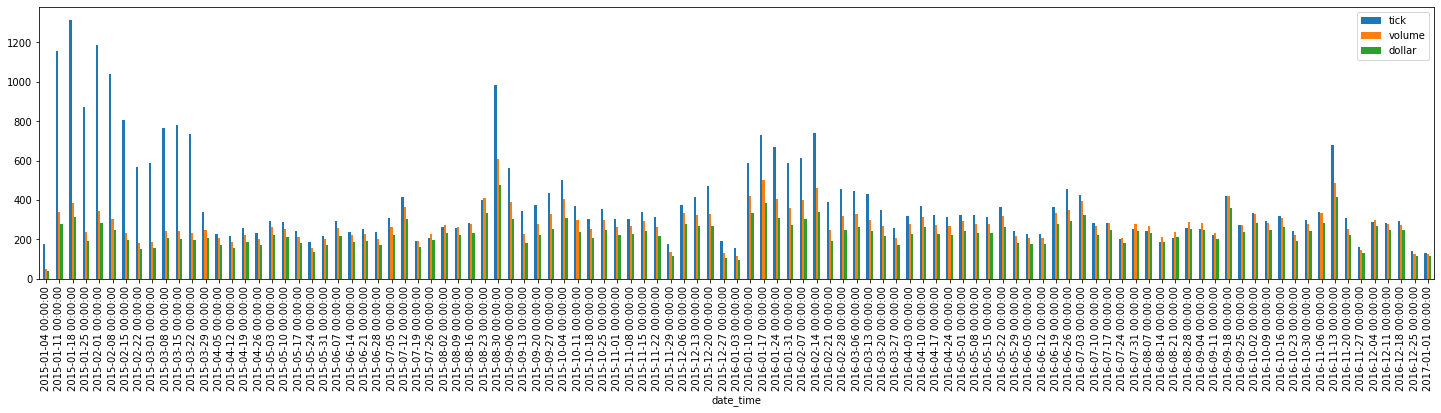

In [3]:
db_ = dollar['close'].resample('W').count()
vb_ = volume['close'].resample('W').count()
tb_ = tick['close'].resample('W').count()

count_df = pd.concat([tb_, vb_, db_], axis=1)
count_df.columns = ['tick', 'volume', 'dollar']
count_df.loc[:, ['tick', 'volume', 'dollar']].plot(kind = 'bar', figsize=[25, 5])

# Tick bars have the most irregular count
# While Dollar bar produces the most stable count per week

In [4]:
p(count_df['dollar'].autocorr())
p(count_df['volume'].autocorr())
p(count_df['tick'].autocorr())

#Dollar bars has the lowest autocorr

0.3082662585319557
0.3653110836430761
0.7012168586776739


In [5]:
db1_ = dollar['close'].resample('M').mean().pct_change().var()
vb1_ = volume['close'].resample('M').mean().pct_change().var()
tb1_ = tick['close'].resample('M').mean().pct_change().var()

p(tb1_, vb1_, db1_)

# Still dollar bar has the lowest variance
# But i suspect you have to resample 1D and 1W as well

0.0008405980471489872 0.0008367515769979635 0.0008319813710860616


In [6]:
from scipy import stats

p(stats.jarque_bera(dollar['close'].pct_change().dropna())[0],
stats.jarque_bera(volume['close'].pct_change().dropna())[0],
stats.jarque_bera(tick['close'].pct_change().dropna())[0])

# Again.. dollar bar.. we r seeing a pattern here

63093.465360938826 82208.37890653765 75737.39864288477


In [7]:
import statsmodels.stats.diagnostic as sm
import statsmodels.api as smi

def bband(data: pd.Series, window: int = 21, width: float = 0.005):
    avg = data.ewm(span = window).mean()
    std0 = avg * width
    lower = avg - std0
    upper = avg + std0
    
    return avg, upper, lower, std0

dollar['avg'], dollar['upper'], dollar['lower'], dollar['std0'] = bband(dollar['close'])


count_dn = dollar[dollar['lower'] > dollar['close']]
count_up = dollar[dollar['upper'] < dollar['close']]
bband_dollar = pd.concat([count_dn, count_up])

raw_bbd = bband_dollar.copy()

p("Total count: {0}\nUpper Bound exceed: {1}\nLower Bound exceed: {2}".format(bband_dollar.count()[0], 
                                                                              count_up.count()[0], 
                                                                              count_dn.count()[0]))

C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Total count: 1836
Upper Bound exceed: 907
Lower Bound exceed: 929


In [8]:
# when you import research as rs
# the below func can be used as rs.cs_filters()

def cumsum_events(df: pd.Series, limit: float):
    idx, _up, _dn = [], 0, 0
    diff = df.diff()
    for i in diff.index[1:]:
        _up, _dn = max(0, _up + diff.loc[i]), min(0, _dn + diff.loc[i])
        if _up > limit:
            _up = 0; idx.append(i)
        elif _dn < - limit:
            _dn = 0; idx.append(i)
        
    return pd.DatetimeIndex(idx)

def cumsum_events1(df: pd.Series, limit: float):
    idx, _up, _dn = [], 0, 0
    diff = df.pct_change()
    for i in diff.index[1:]:
        _up, _dn = max(0, _up + diff.loc[i]), min(0, _dn + diff.loc[i])
        if _up > limit:
            _up = 0; idx.append(i)
        elif _dn < - limit:
            _dn = 0; idx.append(i)
        
    return pd.DatetimeIndex(idx)

event = cumsum_events(bband_dollar['close'], limit = 0.005) # benchmark
event_pct = cumsum_events1(bband_dollar['close'], limit = 0.005)
event_abs = cumsum_events(bband_dollar['close'], limit = bband_dollar['std0'].mean()) # based on ewma std abs estimate 0.005

event_count0 = dollar.reindex(event)
event_count1 = dollar.reindex(event_abs)
event_count2 = dollar.reindex(event_pct)

p("Total count after filter (close price): {0}".format(event_count0.count()[0]))
p("Total count after filter (absolute change): {0}".format(event_count1.count()[0]))
p("Total count after filter (pct change): {0}".format(event_count2.count()[0]))

Total count after filter (close price): 1782
Total count after filter (absolute change): 424
Total count after filter (pct change): 426


## White Test

Heteroscedasticity tests imply the two following hypotheses.

H0 (null hypothesis): data is homoscedastic.

Ha (alternative hypothesis): data is heteroscedastic.

Therefore, if the p-value associated to a heteroscedasticity test falls below a certain threshold (0.05 for example), we would conclude that the data is significantly heteroscedastic.

In [9]:
#event_count['std'] = event_count['close'].rolling(21).std()
#event_count.dropna(inplace= True)

def white_test(data: pd.DataFrame, window: int = 21):
    data['std1'] = data['close'].rolling(21).std()
    data.dropna(inplace= True)
    X = smi.tools.tools.add_constant(data['close'])
    results = smi.regression.linear_model.OLS(data['std1'], X).fit()
    resid = results.resid
    exog = results.model.exog
    p("White-Test p-Value: {0}".format(sm.het_white(resid, exog)[1]))
    if sm.het_white(resid, exog)[1] > 0.05:
        p("White test outcome at 5% signficance: homoscedastic")
    else:
        p("White test outcome at 5% signficance: heteroscedastic")

# Without cumsum filter percentage return based on boillinger band would be more heteroscedastic
# Main reason would be because it would filter out those signal that does not meet threshold requirement.

white_test(raw_bbd) # without filter (less heteroscedastic)
white_test(event_count0) # with filter (close price)

White-Test p-Value: 1.3704431992973026e-08
White test outcome at 5% signficance: heteroscedastic
White-Test p-Value: 3.1055617824761596e-08
White test outcome at 5% signficance: heteroscedastic


In [10]:
# As compared to percentage change vs absolute
# Absolute change in daily price will yield lower p-value (more heteroscedastic)

white_test(event_count1) # absolute return as a filter (less heteroscedastic)
white_test(event_count2) # percent return as a filter

White-Test p-Value: 0.27030043663183695
White test outcome at 5% signficance: homoscedastic
White-Test p-Value: 0.07936943626566823
White test outcome at 5% signficance: homoscedastic


## Conclusion

#### Statistical properties

Dollar bars has the most stable frequency counts, closest to normality and low serial correlation.

Other concerns are stationarity, volatility and moving average, which are not part of this exercise.

#### White test/ Heteroscedasticity test

Absolute return is preferred for cusum filter because the absolute change reflects actual dispersion within prices.

Percentage return however causes short memory if any, plus it's relativity to previous value will cause clustering thus driving up heteroscedasticity.

Absolute return should always be used and based on initial model indicator's std to achieve homoscedastic.